
# DATA fetching (BASKETBALL REF)




In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

def fetch_season_stats(year):
    url = f"https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table', {'id': 'advanced_stats'})

        if not table:
            print(f"Failed to find the advanced stats table for {year}")
            return pd.DataFrame()

        headers = [th.getText() for th in table.thead.find_all('th')]
        headers = headers[1:]  # Remove the first header which is usually a rank or index column

        rows = table.tbody.find_all('tr')

        player_stats = []
        for row in rows:
            if row.find('td'):
                player_data = [td.getText() for td in row.find_all('td')]
                if len(player_data) == len(headers):
                    player_stats.append(player_data)

        if not player_stats:
            print(f"No player data found for {year}")
            return pd.DataFrame()

        df = pd.DataFrame(player_stats, columns=headers)
        return df
    else:
        print(f"Failed to fetch data for {year}")
        return pd.DataFrame()

def fetch_all_nba_teams(year):
    url = f"https://www.basketball-reference.com/awards/awards_{year}.html"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        all_nba_players = []
        tables = soup.find_all('table')
        for table in tables:
            if 'All-NBA' in table.text:
                rows = table.find_all('tr')[1:]
                for row in rows:
                    player_cell = row.find('td', {'data-stat': 'player'})
                    if player_cell and player_cell.a:
                        player = player_cell.a.get_text()
                        all_nba_players.append(player)
        return all_nba_players[:15]
    else:
        print(f"Failed to fetch data for {year}")
        return []

def fetch_rookies(year):
    url = f"https://www.basketball-reference.com/leagues/NBA_{year}_rookies.html"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table')

        if not table:
            print(f"Failed to find the rookies table for {year}")
            return pd.DataFrame()

        headers = [th.getText() for th in table.thead.find_all('th')]

        rows = table.tbody.find_all('tr')
        rookies = []
        for row in rows:
            if row.find('td'):
              #SKipping first 5 headers cuz they meessed up my boy
                rookie_data = {headers[i+5]: td.getText() for i, td in enumerate(row.find_all('td'))}
                rookies.append(rookie_data)

        if not rookies:
            print(f"No rookie data found for {year}")
            return pd.DataFrame()

        df = pd.DataFrame(rookies)
        return df
    else:
        print(f"Failed to fetch rookie data for {year}")
        return pd.DataFrame()

def fetch_all_rookie_teams(year):
    url = f"https://www.basketball-reference.com/awards/awards_{year}.html"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        all_rookie_players = []
        table = soup.find('table', {'id': 'leading_all_rookie'})
        if table:
            rows = table.find_all('tr')[1:]  # Exclude header row
            for row in rows:
                player_cell = row.find('td', {'data-stat': 'player'})
                if player_cell and player_cell.a:
                    player = player_cell.a.get_text()
                    all_rookie_players.append(player)
        return all_rookie_players[:10]
    else:
        print(f"Failed to fetch data for {year}")
        return []

def process_data(raw_data):
    raw_data = raw_data.dropna()
    raw_data = raw_data.apply(pd.to_numeric, errors='ignore')

    tot_rows = raw_data[raw_data['Tm'] == 'TOT']
    unique_players = raw_data[~raw_data['Player'].duplicated(keep=False)]
    raw_data = pd.concat([tot_rows, unique_players])
    return raw_data


def fetching(y1=2019,y2=2024):

  all_data = []

  for year in range(y1, y2):
      stats = fetch_season_stats(year)
      #print(stats)
      processed_stats = process_data(stats)
      all_nba_players = fetch_all_nba_teams(year)
      rookies = fetch_rookies(year)
      all_rookies = fetch_all_rookie_teams(year)

      if rookies.empty:
          print(f"No rookie data for {year}")

      rookie_names = rookies['Player'].tolist() if not rookies.empty else []

      processed_stats['All_NBA'] = processed_stats['Player'].apply(lambda x: 1 if x in all_nba_players else 0)
      processed_stats['Rookie'] = processed_stats['Player'].apply(lambda x: 1 if x in rookie_names else 0)
      processed_stats['ALL_ROOK'] = processed_stats['Player'].apply(lambda x: 1 if x in all_rookies else 0)
      processed_stats['Year'] = year
      all_data.append(processed_stats)

  combined_data = pd.concat(all_data, ignore_index=True)
  combined_data = combined_data.dropna(axis=1)

  if combined_data.empty:
      print("Combined data is empty")
  else:
      print(f"Combined data shape: {combined_data.shape}")

  combined_data = combined_data.dropna(axis=1)
  #X = combined_data.drop(columns=['All_NBA', 'Player'])
  #y = combined_data['All_NBA']
  #X = pd.get_dummies(X)
  return combined_data

combined_data=fetching()




Combined data shape: (2743, 26)


In [ ]:
!pip install selenium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.7/467.7 kB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.3 MB/s eta 0:00:00


In [3]:
combined_data

,Player,Pos,Age,Tm,G,MP,PER,ORB%,DRB%,TRB%,...,WS,WS/48,OBPM,DBPM,BPM,VORP,All_NBA,Rookie,ALL_ROOK,Year
0,Ryan Anderson,PF,30,TOT,25,322,4.6,6.1,12.5,9.2,...,-0.2,-0.035,-4.5,-1.9,-6.4,-0.4,0,0,0,2019
1,Trevor Ariza,SF,33,TOT,69,2349,12.0,2.3,15.2,8.6,...,2.5,0.052,-0.7,-0.6,-1.3,0.4,0,0,0,2019
2,Ron Baker,SG,25,TOT,15,152,2.5,0.7,7.1,3.8,...,-0.1,-0.034,-7.7,0.7,-7.0,-0.2,0,0,0,2019
3,Harrison Barnes,PF-SF,26,TOT,77,2533,12.8,2.4,12.7,7.5,...,3.6,0.068,-0.2,-1.2,-1.4,0.4,0,0,0,2019
4,Avery Bradley,SG,28,TOT,63,1905,7.6,2.5,7.3,4.9,...,0.3,0.009,-2.8,-0.9,-3.7,-0.8,0,0,0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2738,Thaddeus Young,PF,34,TOR,54,795,14.1,9.4,14.6,11.8,...,1.8,0.109,-1.8,1.9,0.1,0.4,0,0,0,2023
2739,Trae Young,PG,24,ATL,73,2541,22.0,2.4,7.0,4.7,...,6.7,0.126,5.3,-2.0,3.3,3.4,0,0,0,2023
2740,Omer Yurtseven,C,24,MIA,9,83,16.7,10.9,21.9,16.2,...,0.3,0.159,-2.5,-1.5,-3.9,0.0,0,0,0,2023
2741,Cody Zeller,C,30,MIA,15,217,16.4,13.0,21.8,17.3,...,0.7,0.147,-2.0,-0.7,-2.8,0.0,0,0,0,2023


In [6]:
combined_data[['All_NBA','VORP', 'OWS', 'DBPM', 'BPM', 'WS','All_NBA','ALL_ROOK','Year']]

,All_NBA,VORP,OWS,DBPM,BPM,WS,All_NBA,ALL_ROOK,Year
0,0,-0.4,-0.3,-1.9,-6.4,-0.2,0,0,2019
1,0,0.4,1.3,-0.6,-1.3,2.5,0,0,2019
2,0,-0.2,-0.2,0.7,-7.0,-0.1,0,0,2019
3,0,0.4,2.0,-1.2,-1.4,3.6,0,0,2019
4,0,-0.8,-0.6,-0.9,-3.7,0.3,0,0,2019
...,...,...,...,...,...,...,...,...,...
2738,0,0.4,0.7,1.9,0.1,1.8,0,0,2023
2739,0,3.4,5.3,-2.0,3.3,6.7,0,0,2023
2740,0,0.0,0.2,-1.5,-3.9,0.3,0,0,2023
2741,0,0.0,0.4,-0.7,-2.8,0.7,0,0,2023


# ALL ROKKIE /NBA SPLIT

#  Random FOrestr fit and Predictions ALL_NBA

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def prepare_data(combined_data, rookie):
    data = combined_data[combined_data['Rookie'] == rookie].drop(columns=['Rookie'])
    y = data['ALL_ROOK' if rookie else 'All_NBA']
    selected_features = ['VORP', 'DWS', 'OWS', 'WS', 'WS/48', 'G', 'Age', 'OBPM', 'BPM', 'MP', 'PER','Year']
    X = pd.get_dummies(data[selected_features])
    return X, y

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=None)
    model = RandomForestClassifier(n_estimators=200, random_state=12)
    model.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, model.predict(X_test))
    print(f"Model Training Accuracy: {accuracy:.2f}")
    return model

def predict_for_year1(model, X_train_columns, stats, year, rookie):
    X_2024 = pd.get_dummies(stats)
    for col in set(X_train_columns) - set(X_2024.columns):
        X_2024[col] = 0
    X_2024 = X_2024[X_train_columns]
    predictions_2024 = model.predict(X_2024)
    stats['All_Prediction'] = predictions_2024
    return stats[stats['All_Prediction'] == 1]

def predict_for_year(model, X_train_columns, stats, year, rookie):
    X_2024 = pd.get_dummies(stats)
    for col in set(X_train_columns) - set(X_2024.columns):
        X_2024[col] = 0
    X_2024 = X_2024[X_train_columns]
    probabilities_2024 = model.predict_proba(X_2024)[:, 1]
    stats['All_Prediction_Probability'] = probabilities_2024
    stats_sorted = stats.sort_values(by='All_Prediction_Probability', ascending=False)
    return stats_sorted[stats_sorted['All_Prediction_Probability'] > 0.5]


def fitpredict(combined_data, rookie=False, year1=2024):
    X, y = prepare_data(combined_data.dropna(axis=1), rookie)
    model = train_model(X, y)

    stats_2024 = fetching(year1, year1+1)
    stats_2024 = stats_2024[stats_2024['Rookie'] == rookie].drop(columns=['Rookie'])

    predicted_2024 = predict_for_year(model, X.columns, stats_2024, year1, rookie)


    actual_players = set(fetch_all_rookie_teams(year1) if rookie else fetch_all_nba_teams(year1))
    predicted_players = set(predicted_2024['Player'])
    correct_predictions = predicted_players & actual_players
    accuracy_2024 = len(correct_predictions) / len(actual_players) if actual_players else 0

    print(f"Predicted All Players for {year1}: {predicted_players}")
    print(f"Actual All Players for {year1}: {actual_players}")
    print(f"Number of Correct Predictions: {len(correct_predictions)}")
    print(f"Prediction Accuracy for {year1}: {accuracy_2024:.2f}")

    return model, predicted_players




In [9]:
model_nba,predicted_nba=fitpredict(combined_data,rookie=False,year1=2024)
model_rookie,predicted_rookie=fitpredict(combined_data,rookie=True,year1=2024)

Model Training Accuracy: 0.96
Combined data shape: (572, 26)
Predicted All Players for 2024: {'Giannis Antetokounmpo', 'Domantas Sabonis', 'Jalen Brunson', 'LeBron James', 'Devin Booker', 'Nikola Jokić', 'Tyrese Haliburton', 'Jayson Tatum', 'Stephen Curry', 'Kevin Durant', 'Joel Embiid', 'Shai Gilgeous-Alexander', 'Luka Dončić', 'Kawhi Leonard', 'Anthony Davis'}
Actual All Players for 2024: {'Giannis Antetokounmpo', 'Jalen Brunson', 'LeBron James', 'Domantas Sabonis', 'Devin Booker', 'Nikola Jokić', 'Tyrese Haliburton', 'Jayson Tatum', 'Stephen Curry', 'Kevin Durant', 'Anthony Edwards', 'Shai Gilgeous-Alexander', 'Luka Dončić', 'Kawhi Leonard', 'Anthony Davis'}
Number of Correct Predictions: 14
Prediction Accuracy for 2024: 0.93
Model Training Accuracy: 1.00
Combined data shape: (572, 26)
Predicted All Players for 2024: {'Brandon Miller', 'Jaime Jaquez Jr.', 'Victor Wembanyama', 'Trayce Jackson-Davis', 'Brandin Podziemski', 'Amen Thompson', 'Cason Wallace', 'Ausar Thompson', 'Dereck Li

# json dumop , model pickle dump

In [10]:

predicted_rookie

{'Amen Thompson',
 'Ausar Thompson',
 'Brandin Podziemski',
 'Brandon Miller',
 'Cason Wallace',
 'Chet Holmgren',
 'Dereck Lively II',
 'Jaime Jaquez Jr.',
 'Trayce Jackson-Davis',
 'Victor Wembanyama'}

In [11]:
predicted_nba

{'Anthony Davis',
 'Devin Booker',
 'Domantas Sabonis',
 'Giannis Antetokounmpo',
 'Jalen Brunson',
 'Jayson Tatum',
 'Joel Embiid',
 'Kawhi Leonard',
 'Kevin Durant',
 'LeBron James',
 'Luka Dončić',
 'Nikola Jokić',
 'Shai Gilgeous-Alexander',
 'Stephen Curry',
 'Tyrese Haliburton'}

In [ ]:
import json

data = {
    "first all-nba team": list(predicted_nba)[:5],
    "second all-nba team": list(predicted_nba)[5:10],
    "third all-nba team": list(predicted_nba)[10:16],
    "first rookie all-nba team": list(predicted_rookie)[:5],
    "second rookie all-nba team": list(predicted_rookie)[5:11]
}

file_path = '/content/Janiszewski_Michal.json'
with open(file_path, 'w') as json_file:
    json.dump(data, json_file,indent=4)

file_path


'/content/Janiszewski_Michal.json'

In [ ]:
import pickle
model_file_path = '/content/model_nba.pkl'
with open(model_file_path, 'wb') as file:
    pickle.dump(model_nba, file)

In [ ]:
import pickle
model_file_path = '/content/model_rookie.pkl'
with open(model_file_path, 'wb') as file:
    pickle.dump(model_rookie, file)

# Feature selection based on interclass variance and Permuation matrix scores / not necessary

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.3 MB/s eta 0:00:00


Top 6 features:  Index(['VORP', 'DBPM', 'BPM', 'OWS', 'OBPM', 'WS', 'DWS', 'WS/48', 'MP',
       'AST%'],
      dtype='object')


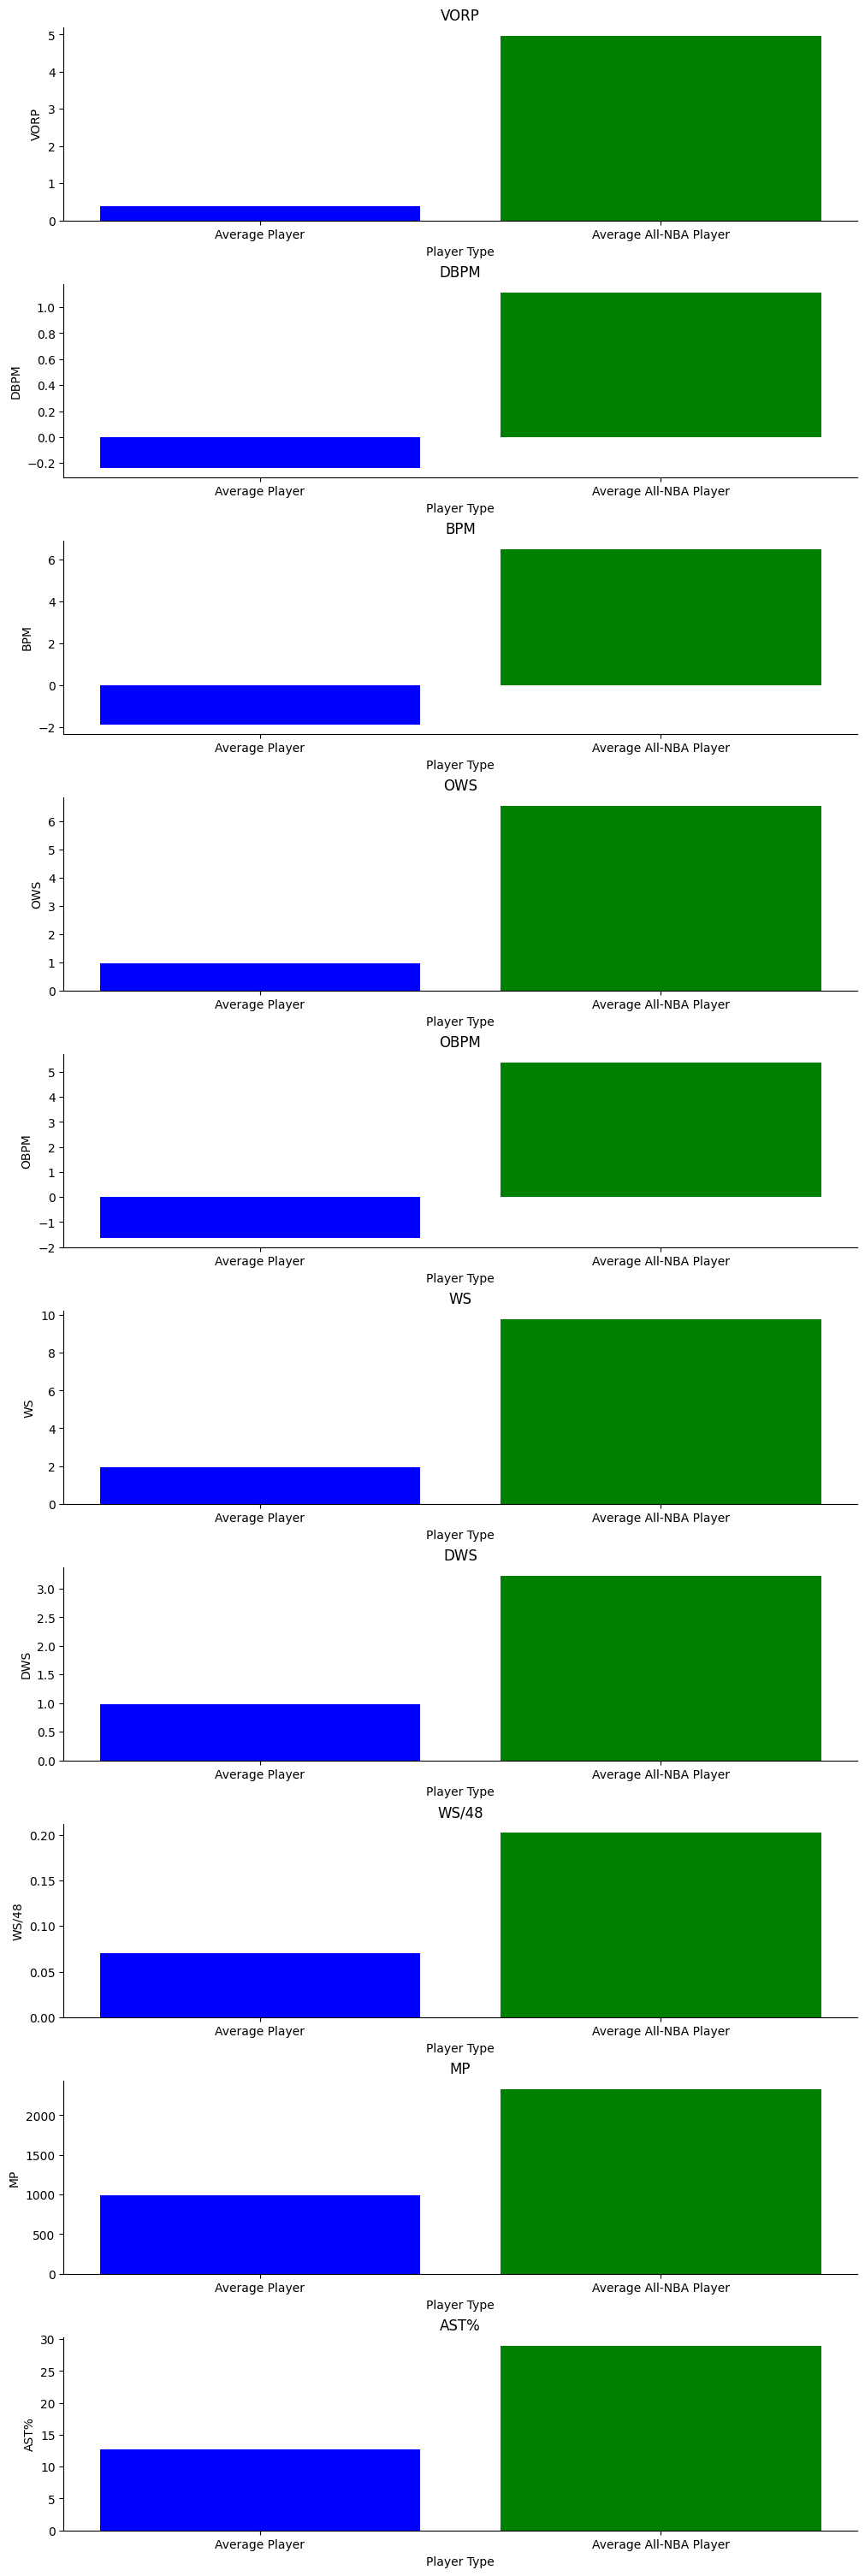

In [ ]:

all_nba_players = combined_data[combined_data['All_NBA'] == 1]
other_players = combined_data[combined_data['All_NBA'] == 0]

numeric_columns = combined_data.select_dtypes(include=[np.number]).columns.difference(['All_NBA', 'Rookie', 'Year'])

mean_all_nba = all_nba_players[numeric_columns].mean()
mean_other = other_players[numeric_columns].mean()

overall_mean = combined_data[numeric_columns].mean()
normalized_all_nba = mean_all_nba / overall_mean
normalized_other = mean_other / overall_mean

relative_mean_diff = (normalized_all_nba - normalized_other).abs()

top_features = relative_mean_diff.nlargest(10).index
print("Top 10 features: ", top_features)

n_cols = len(top_features)

fig, axes = plt.subplots(n_cols, 1, figsize=(10, n_cols * 3), constrained_layout=True)

for idx, col in enumerate(top_features):
    axes[idx].bar(['Average Player', 'Average All-NBA Player'], [mean_other[col], mean_all_nba[col]], color=['blue', 'green'])
    axes[idx].set_title(col)
    axes[idx].set_ylabel(col)
    axes[idx].set_xlabel('Player Type')
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)

plt.show()




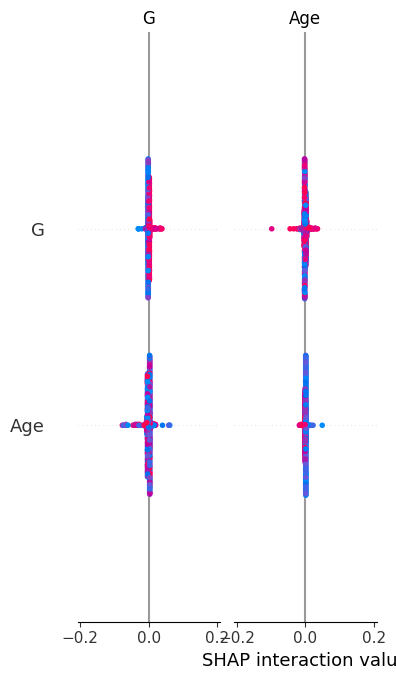

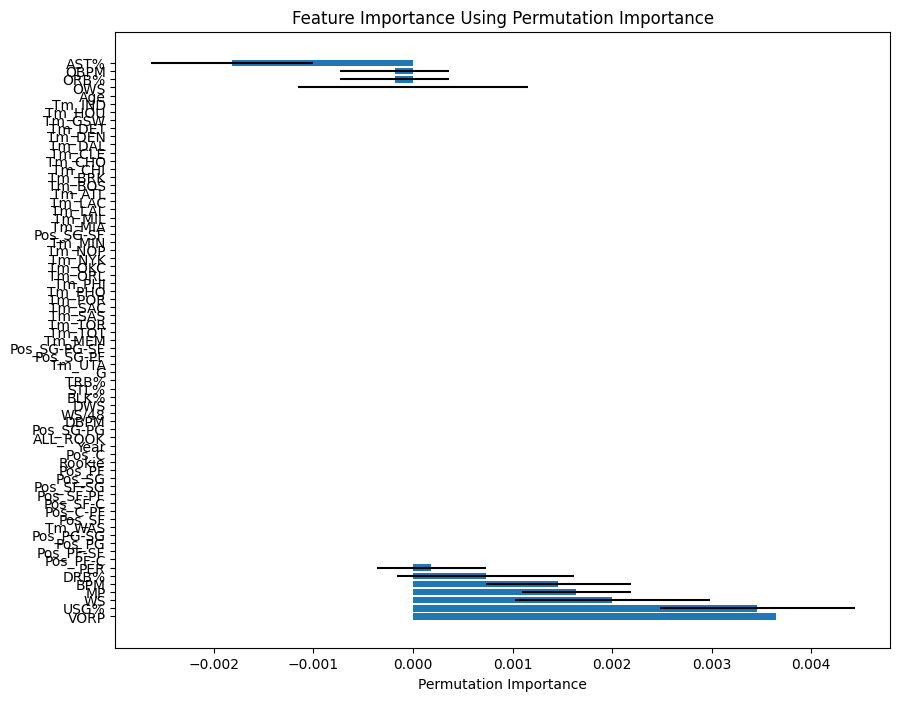

Top 10 features by permutation importance:
VORP: 0.0036
USG%: 0.0035
WS: 0.0020
MP: 0.0016
BPM: 0.0015
DRB%: 0.0007
PER: 0.0002
Pos_PF-C: 0.0000
Pos_PF-SF: 0.0000
Pos_PG: 0.0000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.inspection import permutation_importance

X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=40)
sorted_idx = perm_importance.importances_mean.argsort()

feature_names = X_test.columns[sorted_idx]
importances = perm_importance.importances_mean[sorted_idx]
std = perm_importance.importances_std[sorted_idx]

plt.figure(figsize=(15, 8))
plt.barh(range(len(importances)), importances, xerr=std, align='center')
plt.yticks(range(len(importances)), feature_names)
plt.xlabel("Permutation Importance")
plt.title("Feature Importance Using Permutation Importance")
plt.gca()
plt.show()

top_10_features = sorted_idx[-10:]
print("Top 10 features by permutation importance:")
for i in top_10_features[::-1]:
    print(f"{X_test.columns[i]}: {perm_importance.importances_mean[i]:.4f}")


# Feature importance using permutation importance:
VORP: 0.0068
USG%: 0.0041
OWS: 0.0041
WS: 0.0040
WS/48: 0.0037
BPM: 0.0037
MP: 0.0030
DWS: 0.0028
G: 0.0021
Tm_PHI: 0.0014
Tm_UTA: 0.0014
ORB%: 0.0013
Pos_PG: 0.0013
Pos_SG: 0.0004
Age: 0.0003

# INTERCLASS VARIANCE
['VORP', 'DBPM', 'BPM', 'OWS', 'OBPM', 'WS', 'DWS', 'WS/48', 'MP',
       'AST%'

# COMMON BITWISE OR AND XOR common sense

['VORP','DWS,'OWS','WS','WS/48','G','Age','OBPM','BPM','MP','PER']

# Initial commit / not used

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import requests
from bs4 import BeautifulSoup

def fitpredict(combined_data,rookie=False,year1=2024):

  # fITTING THE MODEL
  combined_data = combined_data.dropna(axis=1)
  data_rookie = combined_data[combined_data['Rookie'] == 1].drop(columns=['Rookie'])
  data_nba = combined_data[combined_data['Rookie'] == 0].drop(columns=['Rookie'])

  if rookie==True:
    combined_data = data_rookie
    print(combined_data['ALL_ROOK'])
    y = combined_data['ALL_ROOK']
  else:
    combined_data = data_nba
    y = combined_data['All_NBA']

  selected_features = ['VORP', 'DWS', 'OWS', 'WS', 'WS/48', 'G', 'Age', 'OBPM', 'BPM', 'MP', 'PER']
  X = combined_data[selected_features]
  #X = combined_data.drop(columns=['All_NBA', 'Player'])
  X = pd.get_dummies(X)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=4)

  model = RandomForestClassifier(n_estimators=200, random_state=56)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)
  accuracy = accuracy_score(y_test, predictions)
  print(f"Model Training Accuracy: {accuracy:.2f}")


  # PREDICTION FOR 2024
  stats_2024 = fetching(year1,year1+1)

  if rookie==True:
    rookie24 = stats_2024[stats_2024['Rookie'] == 1].drop(columns=['Rookie'])
    stats=rookie24
    X_2024 = stats[selected_features]
    actual_all_nba_2024 = fetch_all_rookie_teams(year1)
  else:
    nba24 = stats_2024[stats_2024['Rookie'] == 0].drop(columns=['Rookie'])
    stats=nba24
    X_2024 = stats[selected_features]
    actual_all_nba_2024 = fetch_all_nba_teams(year1)


  X_2024 = pd.get_dummies(X_2024)

  missing_cols = set(X_train.columns) - set(X_2024.columns)
  for col in missing_cols:
      X_2024[col] = 0

  X_2024 = X_2024[X_train.columns]

  predictions_2024 = model.predict(X_2024)


  X_2024['All_Prediction'] = predictions_2024


  predicted_all_nba_2024 = stats[X_2024['All_Prediction'] == 1]
  print(predicted_all_nba_2024[['Player', 'Pos', 'Tm']])


  predicted_players = set(predicted_all_nba_2024['Player'])
  actual_players = set(actual_all_nba_2024)
  correct_predictions = predicted_players & actual_players
  accuracy_2024 = len(correct_predictions) / len(actual_players)

  print(f"Predicted All Players for {year1}: {predicted_players}")
  print(f"Actual All Players for {year1}: {actual_players}")
  print(f"Number of Correct Predictions: {len(correct_predictions)}")
  print(f"Prediction Accuracy for {year1}: {accuracy_2024:.2f}")
  return (model,predicted_players)



Model Training Accuracy: 0.96
Combined data shape: (572, 26)
                      Player Pos   Tm
86     Giannis Antetokounmpo  PF  MIL
117             Devin Booker  PG  PHO
136            Jalen Brunson  PG  NYK
141             Jimmy Butler  PF  MIA
171            Stephen Curry  PG  GSW
173            Anthony Davis   C  LAL
183              Luka Dončić  PG  DAL
192             Kevin Durant  PF  PHO
195          Anthony Edwards  SG  MIN
198              Joel Embiid   C  PHI
218  Shai Gilgeous-Alexander  PG  OKC
239        Tyrese Haliburton  PG  IND
290             LeBron James  PF  LAL
302             Nikola Jokić   C  DEN
332            Kawhi Leonard  SF  LAC
457         Domantas Sabonis   C  SAC
498             Jayson Tatum  PF  BOS
Predicted All Players for 2024: {'Jalen Brunson', 'Anthony Davis', 'Luka Dončić', 'LeBron James', 'Anthony Edwards', 'Kevin Durant', 'Stephen Curry', 'Nikola Jokić', 'Domantas Sabonis', 'Jayson Tatum', 'Kawhi Leonard', 'Devin Booker', 'Joel Embiid', 'Gian